# CNN'S TRAINING, PERFORMANCE AND ANALYSIS

## CNN'S TRAINING

In this script we load our dataset from a Github folder and we train our Convolutional Neural Network

In [ ]:
!git clone https://github.com/Marigra98/Turing-Dataset

Cloning into 'Turing-Dataset'...
remote: Enumerating objects: 5024, done.
remote: Counting objects: 100% (633/633), done.
remote: Compressing objects: 100% (598/598), done.
remote: Total 5024 (delta 56), reused 560 (delta 35), pack-reused 4391
Receiving objects: 100% (5024/5024), 349.88 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (587/587), done.


In [ ]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'1.13.1+cu116'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import requests
import zipfile
from pathlib import Path

In [ ]:
import random
from PIL import Image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Here we load the Training data (1577 images) and the Validation data (275 images, i.e. 15% of the total data). 

The dataset is composed of images belonging 5 different classes: homogeneous, labyrinths, mixed spots-stripes, reversed spots, reversed spost & worms

Our images are 99x99 grayscale images. All images are normalized by 0 and 1, except for the homogeneous patterns, which have a constant value of 0.5 or 0.59.

Our dataset consists of Matlab files, which are dictionary-type data, in which there is information on the matrix, the label and the parameters B and C associated with the pattern

In [ ]:
# Setup train and testing paths
image_path = Path('/content/Turing-Dataset/DATASET.m')
train_dir1 = image_path / "Training"
train_dir2 = image_path / "Training2"
test_dir = image_path / "Validation"

train_dir1, train_dir2, test_dir

(PosixPath('/content/Turing-Dataset/DATASET.m/Training'),
 PosixPath('/content/Turing-Dataset/DATASET.m/Training2'),
 PosixPath('/content/Turing-Dataset/DATASET.m/Validation'))

Since the data is 99x99 numpy arrays, we preprocess the data to add the channel information

In [ ]:
def preprocessing(M):
    height, width = M.shape
    M=M.reshape(height, width, 1,1)

    M=np.transpose(M,(2,3,0,1))
   
    return M

In [ ]:
#We create x_train and y_train
import os, sys
import scipy.io

x_train=np.empty((0,1,99,99))
y_train=np.empty((0,5))
yy_train =np.empty((0))
name_train =np.empty((0))

path_train_vec= ['/content/Turing-Dataset/DATASET.m/Training','/content/Turing-Dataset/DATASET.m/Training2']

for path_train in path_train_vec:
  for i in range(len(os.listdir(path_train))):
      file_name=path_train+'/'+os.listdir(path_train)[i]
      mat = scipy.io.loadmat(file_name)
      M=mat.get('M')
      label=mat.get('pattern')
      label=label[0]

      M=preprocessing(M)
      x_train=np.vstack((x_train,M))
      name_train=np.append(name_train,file_name)

      if label=='homogeneous':
        label=np.array([1,0,0,0,0])
        y_train=np.vstack((y_train,label))
        yy_train=np.append(yy_train,0)
        
        
      if label=='mixed spots-stripes':
        label=np.array([0,0,1,0,0])
        y_train=np.vstack((y_train,label))
        yy_train=np.append(yy_train,2)

      if label=='reversed spots & worms':
        label=np.array([0,0,0,0,1])
        y_train=np.vstack((y_train,label))
        yy_train=np.append(yy_train,4)

      if label=='reversed spots':
        label=np.array([0,0,0,1,0])
        y_train=np.vstack((y_train,label))
        yy_train=np.append(yy_train,3)

      if label=='labyrinths':
        label=np.array([0,1,0,0,0])
        y_train=np.vstack((y_train,label))
        yy_train=np.append(yy_train,1)

In [ ]:
#We create x_val and y_val
x_val=np.empty((0,1,99,99))
y_val=np.empty((0,5))
yy_val =np.empty((0))
name_val =np.empty((0))

path_val= '/content/Turing-Dataset/DATASET.m/Validation'

for i in range(len(os.listdir(path_val))):
    file_name=path_val+'/'+os.listdir(path_val)[i]
    mat = scipy.io.loadmat(file_name)
    M=mat.get('M')
    label=mat.get('pattern')
    label=label[0]

    M=preprocessing(M)
    x_val=np.vstack((x_val,M))
    name_val=np.append(name_val,file_name)

    if label=='homogeneous':
      label=np.array([1,0,0,0,0])
      y_val=np.vstack((y_val,label))
      yy_val=np.append(yy_val,0)
      
    if label=='mixed spots-stripes':
      label=np.array([0,0,1,0,0])
      y_val=np.vstack((y_val,label))
      yy_val=np.append(yy_val,2)

    if label=='reversed spots & worms':
      label=np.array([0,0,0,0,1])
      y_val=np.vstack((y_val,label))
      yy_val=np.append(yy_val,4)

    if label=='reversed spots':
      label=np.array([0,0,0,1,0])
      y_val=np.vstack((y_val,label))
      yy_val=np.append(yy_val,3)

    if label=='labyrinths':
      label=np.array([0,1,0,0,0])
      y_val=np.vstack((y_val,label))
      yy_val=np.append(yy_val,1)

In [ ]:
x_val.shape

(275, 1, 99, 99)

In [ ]:
#we convert data from numpy array to torch tensor
from torch.utils.data import TensorDataset, DataLoader

tensor_x_train = torch.Tensor(x_train)
tensor_y_train = torch.Tensor(y_train)

tensor_x_val=torch.Tensor(x_val)
tensor_y_val=torch.Tensor(y_val)

In [ ]:
train_dataset=TensorDataset(tensor_x_train,tensor_y_train)
test_dataset=TensorDataset(tensor_x_val,tensor_y_val)

We create our NN DataLoader using batch size=64

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=64,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=64, 
                             num_workers=1, 
                             shuffle=False)

Here is the Convolutional Neural Network architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(128*1*1, 5),
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.softmax(self.linear_block(x),dim=1)
        return x

In [ ]:
torch.manual_seed(42)
model=Net().to(device)

In [ ]:
from torchsummary import summary

In [ ]:
summary(model, (1, 99, 99))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 99, 99]              80
       BatchNorm2d-2            [-1, 8, 99, 99]              16
              ReLU-3            [-1, 8, 99, 99]               0
         AvgPool2d-4            [-1, 8, 49, 49]               0
            Conv2d-5           [-1, 16, 49, 49]           1,168
       BatchNorm2d-6           [-1, 16, 49, 49]              32
              ReLU-7           [-1, 16, 49, 49]               0
         AvgPool2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 24, 24]           4,640
      BatchNorm2d-10           [-1, 32, 24, 24]              64
             ReLU-11           [-1, 32, 24, 24]               0
        AvgPool2d-12           [-1, 32, 12, 12]               0
           Conv2d-13           [-1, 32, 12, 12]           9,248
      BatchNorm2d-14           [-1, 32,

In [ ]:
! pip install -q torchview
! pip install -q -U graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 2.2 MB/s eta 0:00:00


In [ ]:
from torchview import draw_graph
from torchvision.models import resnet18, GoogLeNet, densenet, vit_b_16
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

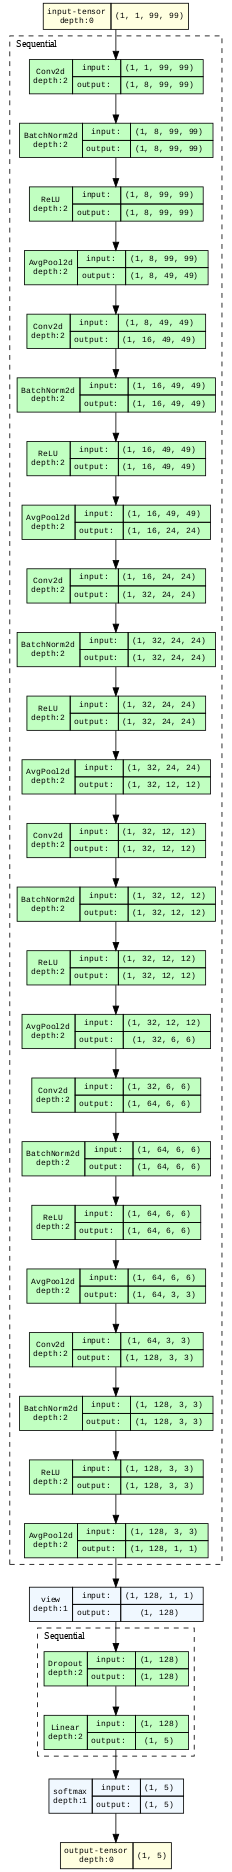

In [ ]:
#Plot of the CNN architecture
model_graph = draw_graph(model, input_size=(1,1,99,99), expand_nested=True)
model_graph.visual_graph

We define a train_step function to compute the decrease in loss function and increase in accuracy of our CNN on the training data

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class =torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        y2 = torch.argmax(torch.softmax(y, dim=1), dim=1)
        train_acc += (y_pred_class == y2).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

We define a test_step function to compute the decrease in loss function and increase in accuracy of our CNN on the validation data

In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            y1 = torch.argmax(torch.softmax(y, dim=1), dim=1)
            test_acc += ((test_pred_labels == y1).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

We create a train function to combine the outputs of the previous train_step and test_strep function

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

We start to train the CNN. 

We use 20 epochs, the MSE Loss Function, the SGDM with learning rate=0.001 and momentum=0.9

In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model = Net().to(device)

# Setup loss function and optimizer
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn=nn.MSELoss()
#loss_fn=torch.nn.functional.nll_loss
learning_rate=0.001
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1436 | train_acc: 0.4820 | test_loss: 0.1592 | test_acc: 0.3760
Epoch: 2 | train_loss: 0.1006 | train_acc: 0.7955 | test_loss: 0.0950 | test_acc: 0.7391
Epoch: 3 | train_loss: 0.0751 | train_acc: 0.8191 | test_loss: 0.0650 | test_acc: 0.7946
Epoch: 4 | train_loss: 0.0634 | train_acc: 0.8221 | test_loss: 0.0541 | test_acc: 0.8113
Epoch: 5 | train_loss: 0.0554 | train_acc: 0.8267 | test_loss: 0.0517 | test_acc: 0.8008
Epoch: 6 | train_loss: 0.0493 | train_acc: 0.8401 | test_loss: 0.0449 | test_acc: 0.8551
Epoch: 7 | train_loss: 0.0436 | train_acc: 0.8716 | test_loss: 0.0410 | test_acc: 0.8738
Epoch: 8 | train_loss: 0.0425 | train_acc: 0.8913 | test_loss: 0.0381 | test_acc: 0.9207
Epoch: 9 | train_loss: 0.0399 | train_acc: 0.8959 | test_loss: 0.0354 | test_acc: 0.9289
Epoch: 10 | train_loss: 0.0362 | train_acc: 0.9147 | test_loss: 0.0321 | test_acc: 0.9414
Epoch: 11 | train_loss: 0.0343 | train_acc: 0.9285 | test_loss: 0.0310 | test_acc: 0.9414
Epoch: 12 | train_l

## CNN'S PERFORMANCE

We plot the loss function and the accuracy computed on both training data and validation data

In [ ]:
def plot_loss_curves(results):
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

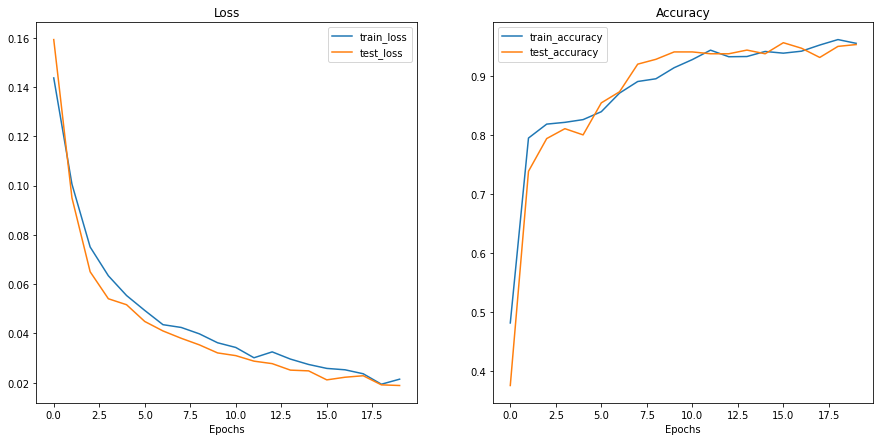

In [ ]:
plot_loss_curves(model_results)

In [ ]:
model.state_dict();

We save the resulting weights of the trained CNN

In [ ]:
# Save the architecture and the weights
torch.save(model.state_dict(), "CNN_trained.pt")

## ANALYSIS ON CNN'S PREDICTIONS

Here we test our CNN's predictions

In [ ]:
CNN=Net()
CNN.load_state_dict(torch.load('/content/Turing-Dataset/CNN_trained.pt',map_location=torch.device('cpu')))
CNN.eval();

We compute the final accuracy values on both training and validation data

In [ ]:
n, ch, h, w=x_train.shape
y_pred_train=np.array([])

for i in range(n):
    image = x_train[i:i+1].reshape(1,99,99).transpose(1,2,0)
    with torch.no_grad():
      pred = CNN(torch.tensor(image).permute(2,0,1).unsqueeze(0).float())
    y_pred_train=np.append(y_pred_train,np.argmax(pred.numpy()))

In [ ]:
n, ch, h, w=x_val.shape
y_pred_val=np.array([])

for i in range(n):
    image = x_val[i:i+1].reshape(1,99,99).transpose(1,2,0)
    with torch.no_grad():
      pred = CNN(torch.tensor(image).permute(2,0,1).unsqueeze(0).float())
    y_pred_val=np.append(y_pred_val,np.argmax(pred.numpy()))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Train Accuracy: ', accuracy_score(yy_train, y_pred_train))
print('Val Accuracy: ', accuracy_score(yy_val, y_pred_val))

Train Accuracy:  0.9653731343283583
Val Accuracy:  0.9381818181818182


In [ ]:
print(classification_report(yy_train, y_pred_train, target_names=["Homog", "Lab", "Mixed S-S", "Rev S", "Rev S&W"]))
print(classification_report(yy_val, y_pred_val, target_names=["Homog", "Lab", "Mixd S-S", "Rev S", "Rev S&W"]))

              precision    recall  f1-score   support

       Homog       1.00      1.00      1.00       301
         Lab       0.97      0.90      0.94       240
   Mixed S-S       1.00      0.97      0.99       235
       Rev S       0.93      1.00      0.96       375
     Rev S&W       0.96      0.94      0.95       524

    accuracy                           0.97      1675
   macro avg       0.97      0.96      0.97      1675
weighted avg       0.97      0.97      0.97      1675

              precision    recall  f1-score   support

       Homog       1.00      1.00      1.00        40
         Lab       0.88      0.84      0.86        55
    Mixd S-S       1.00      0.90      0.95        61
       Rev S       0.97      1.00      0.98        60
     Rev S&W       0.86      0.97      0.91        59

    accuracy                           0.94       275
   macro avg       0.94      0.94      0.94       275
weighted avg       0.94      0.94      0.94       275



Below we represent the confusion matrix on the validation data

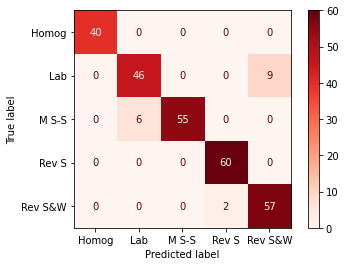

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

cm = metrics.confusion_matrix(yy_val, y_pred_val)

labels =["Homog", "Lab", "M S-S", "Rev S", "Rev S&W"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = disp.plot(cmap=plt.cm.Reds, values_format="g")
plt.show()